In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import warnings

from deepemogp import feature_extractor
from deepemogp.signal import physio as physio
from deepemogp import datasets as datasets
from deepemogp.signal import behavior as behavior

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)
scaler = StandardScaler()

In [3]:
show = False
# definition of the feature extractors to be used later
f2 = feature_extractor.FE('wavelet', window=(2, 1))
f3 = feature_extractor.FE('mean', window=(1,0))

# definition of the physiological signals to be extracted
eda_ = physio.EDA(f3)
hr_ = physio.HR(f3)
pupil_ = behavior.PUPIL(f3)


# extraction of the desired data from the dataset
d = datasets.FEAR(signals={hr_,pupil_,eda_}, subjects={'45'})

for s in d.signals:
    # preprocess ...
    if s.name =='EDA':
        s.preprocess(show=show,new_fps=500)
        s.feature_ext.extract_feat(s,show=show)
    else:
        if s.name == 'HR':
            list_hr_test = s.raw[0]['data']
            s.preprocess(show=show, useneurokit=True)
            s.feature_ext.extract_feat(s,show=show)

        else:
            s.feature_ext.extract_feat_without_preprocess(s, show=show)

for sig in d.signals:
    if sig.name=='EDA':
        eda_data = sig.features
    if sig.name=='HR':
        hr_data = sig.features
    if sig.name=='PUPIL':
        pupil_data = sig.features

>> Loading PUPIL for subject 45 and all sessions from dataset FEAR
>> Loading HR for subject 45 and all sessions from dataset FEAR
>> Loading EDA for subject 45 and all sessions from dataset FEAR
>> Extracting mean features from PUPIL signal, adopting (1, 0) window ...
>> Processing HR ... using neurokit


/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis

>> Extracting mean features from HR signal, adopting (1, 0) window ...
>> Processing EDA ...
>> Extracting mean features from EDA signal, adopting (1, 0) window ...


In [4]:
TRIAL = 160
hr = np.array(hr_data)
hr = hr.reshape((TRIAL, int(hr.shape[0] / TRIAL * hr.shape[1])))
pupil = np.array(pupil_data)
pupil = pupil.reshape((TRIAL, int(pupil.shape[0] / TRIAL * pupil.shape[1])))
eda = np.array(eda_data)
eda = eda.reshape((TRIAL, int(eda.shape[0] / TRIAL * eda.shape[1])))

In [6]:
trial_i = 113
index = np.arange(6)
hr_trial = hr[trial_i]
eda_trial = eda[trial_i]

coords_ = {'time':index, 'hr_': hr_trial, 'eda_':eda_trial}
coords_

{'time': array([0, 1, 2, 3, 4, 5]),
 'hr_': array([141.8857144 , 158.83336858, 138.11937399, 117.17355808,
        128.07816207, 149.82723018]),
 'eda_': array([0.0937584 , 0.09504176, 0.25697106, 0.29961316, 0.22274746,
        0.35046387])}

In [7]:
with pm.Model(coords=coords_) as rolling:
    sigma_alpha = pm.Exponential("sigma_alpha", 50.0)
    sigma_beta = pm.Exponential("sigma_beta", 50.0)

    alpha = pm.GaussianRandomWalk(
        "alpha", sigma=sigma_alpha, init_dist=pm.Normal.dist(0, 10), dims="time"
    )
    beta = pm.GaussianRandomWalk(
        "beta", sigma=sigma_beta, init_dist=pm.Normal.dist(0, 10), dims="time"
    )
    regression = alpha + beta * coords_['hr_']

    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal("sd", sigma=0.1)
    likelihood = pm.Normal("y", mu=regression, sigma=sd, observed=coords_['eda_'])

In [8]:
graph_rolling = pm.model_to_graphviz(rolling)
graph_rolling.view('rolling_regr')

'rolling_regr.pdf'

In [9]:
with rolling:
    trace = pm.sample(tune=2000, target_accept=0.9)

/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/Users/marcoghezzi/PycharmProjects/pythonProject/ven

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 198 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8193, but should be close to 0.9. Try to increase the number of tuning steps.
There were 344 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4093, but should be close to 0.9. Try to increase the number of tuning steps.
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a

In [10]:
with rolling:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

Sampling: [y]


In [11]:
eda_pred = posterior_predictive.posterior_predictive['y']
eda_pred

<xarray.DataArray 'y' (chain: 2, draw: 1000, y_dim_0: 6)>
array([[[ 0.15381995,  0.2083596 ,  0.24471455,  0.22522992,
          0.2964947 ,  0.39839185],
        [ 0.07140092,  0.08350944,  0.14230352,  0.29449636,
          0.2339945 ,  0.30501307],
        [-0.0622417 ,  0.06390629,  0.16412292, -0.05704612,
          0.26651256,  0.0951796 ],
        ...,
        [ 0.22864317,  0.20307753,  0.13685822,  0.51027048,
          0.30087953,  0.41599024],
        [ 0.27717893,  0.08397979,  0.26570681,  0.42533844,
          0.37763434,  0.30489423],
        [ 0.07823977,  0.05967651,  0.19803993,  0.36412746,
          0.37783474,  0.35052436]],

       [[ 0.09427957,  0.09806273,  0.29160629,  0.17632448,
          0.34503907,  0.4068118 ],
        [ 0.0906138 ,  0.10812733,  0.30709131,  0.27751923,
          0.31489449,  0.3297029 ],
        [ 0.09331002,  0.13322149,  0.28509027,  0.29463697,
          0.17239804,  0.18123392],
        ...,
        [ 0.1815091 ,  0.16231852,  0.28999681,  0.36720208,
          0.31642853,  0.23766984],
        [ 0.090567  ,  0.42703409,  0.34589344,  0.16864009,
          0.27809197,  0.25698082],
        [ 0.20745329,  0.13122754,  0.25067852,  0.36132731,
          0.24967626,  0.29827198]]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * y_dim_0  (y_dim_0) int64 0 1 2 3 4 5

<AxesSubplot: xlabel='y / y'>

/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


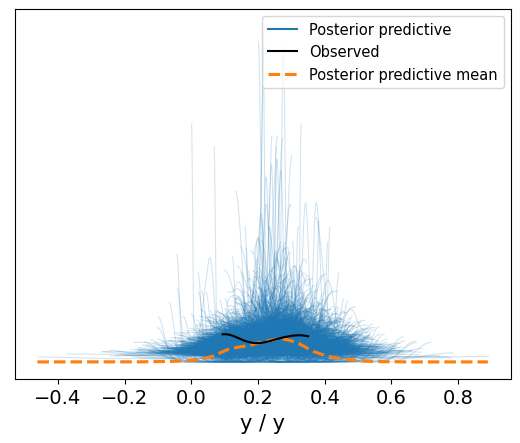

In [12]:
az.plot_ppc(posterior_predictive,)

In [17]:
eda_pred_mean = np.squeeze(stats.mode(eda_pred[0], keepdims=False)[0])[:,np.newaxis]

[[-0.4612165 ]
 [-0.37328343]
 [-0.26462501]
 [-0.17290154]
 [-0.12677294]
 [-0.15481344]] [0.0937584  0.09504176 0.25697106 0.29961316 0.22274746 0.35046387]


In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mean_squared_error(coords_['eda_'], eda_pred_mean)

0.23335465201278924

In [20]:
mean_absolute_error(coords_['eda_'], eda_pred_mean)

0.47870143144579985

In [21]:
final_df = pd.DataFrame()


array([[133.2741004 , 138.05798435, 137.23671541, 140.61746764,
        145.47411312, 144.43909485, 130.15184382, 136.2229583 ,
        131.5212626 , 134.64991023, 135.99263469, 125.43597512,
        127.25344645, 133.76644362, 137.26933037, 140.4494382 ,
        148.57257359, 163.48773842, 150.58852461, 148.10619198,
        146.484375  , 140.25245442, 143.02503702, 147.73507894,
        141.08565596, 148.66204163, 144.71780029, 136.98630137,
        136.64230821, 127.52391073, 138.56958185, 136.9237791 ,
        143.12977099, 133.73524212, 135.86956522, 148.42328284,
        145.84346135, 148.8218272 , 138.82461823, 136.86131387,
        133.4519573 , 142.58555133, 126.88443493, 141.32506856,
        131.00436681, 136.90103594, 135.37488221, 135.74660633,
        138.6962552 , 137.48854262, 137.80431787, 135.29488726,
        132.62599469, 142.11274278, 133.99917535, 132.98076973,
        134.07427424, 134.33813577, 137.36263736, 134.91643711,
        140.1245679 , 131.34851138, 135.